<a href="https://colab.research.google.com/github/mdrk300902/demo-repo/blob/main/MobileNetV2_Flower_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MobileNetV2 Flower Classification (TensorFlow)

Classify flower images using transfer learning with MobileNetV2 on the tf_flowers dataset, including data augmentation, early stopping, and evaluation metrics visualizations.


Mount Google Drive to save and access model weights.

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Install TensorFlow and TensorFlow Datasets, and import all necessary libraries.


In [19]:
!pip install -Uqq tensorflow tensorflow-datasets

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

Define image, model, and training parameters, as well as output location.

In [20]:
# Settings
DATASET_NAME = 'tf_flowers'
NUM_CLASSES = 5
IMG_SIZE = (128, 128)
BATCH_SIZE = 16
BUFFER_SIZE = 1000
BASE_MODEL = tf.keras.applications.MobileNetV2
FREEZE_LAYERS = True
INPUT_SHAPE = IMG_SIZE + (3,)
INITIAL_EPOCHS = 25
PATIENCE = 3
VALIDATION_SPLIT = 0.2
SAVE_PATH = "/content/drive/MyDrive/flower_classifier.keras"

Load the dataset, apply augmentation and preprocessing, and batch the data for training, validation, and testing.

In [32]:
def preprocess_image(image, label):
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image, label

def data_augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    image = tf.image.random_saturation(image, lower=0.8, upper=1.2)
    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image)
    return image, label

(ds_train, ds_validation, ds_test), ds_info = tfds.load(
    name=DATASET_NAME,
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    as_supervised=True,
    with_info=True
)
train_ds = ds_train.map(data_augment, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = ds_validation.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_ds = ds_test.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

Preview a batch of augmented images from the training set.


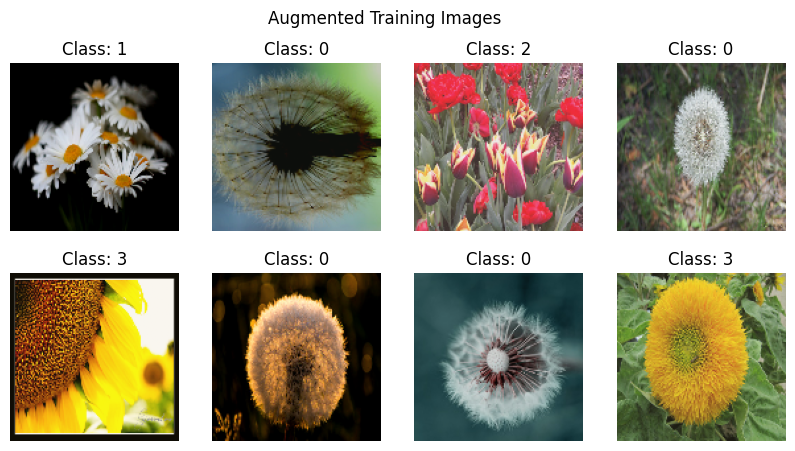

In [22]:
# Visualize one batch
plt.figure(figsize=(10,5))
for batch_images, batch_labels in train_ds.take(1):
    for i in range(8):
        plt.subplot(2,4,i+1)
        img = (batch_images[i].numpy()+1.)/2.
        img = np.clip(img, 0, 1)
        plt.imshow(img)
        plt.title(f"Class: {batch_labels[i].numpy()}")
        plt.axis('off')
plt.suptitle("Augmented Training Images")
plt.show()

Build a MobileNetV2 model with a custom classification head and summarize architecture.


In [23]:
base_model = BASE_MODEL(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
if FREEZE_LAYERS:
    base_model.trainable = False
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(NUM_CLASSES, activation='softmax')
])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,264,389 (8.64 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Configure optimizer, loss, metrics, and callbacks for best model saving and early stopping.


In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=PATIENCE,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath=SAVE_PATH,
        save_best_only=True,
        monitor='val_accuracy'
    )
]

Train the model and validate using the defined callbacks.


In [26]:
history = model.fit(
    train_ds,
    epochs=INITIAL_EPOCHS,
    validation_data=val_ds,
    callbacks=callbacks
)

Epoch 1/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 29s 139ms/step - accuracy: 0.6544 - loss: 0.9206 - val_accuracy: 0.8610 - val_loss: 0.3944
Epoch 2/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 24s 53ms/step - accuracy: 0.8576 - loss: 0.4149 - val_accuracy: 0.8665 - val_loss: 0.3462
Epoch 3/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.8854 - loss: 0.3315 - val_accuracy: 0.8719 - val_loss: 0.3549
Epoch 4/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.8978 - loss: 0.2939 - val_accuracy: 0.8665 - val_loss: 0.3209
Epoch 5/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.9104 - loss: 0.2596 - val_accuracy: 0.8774 - val_loss: 0.3362
Epoch 6/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - accuracy: 0.9011 - loss: 0.2592 - val_accuracy: 0.8801 - val_loss: 0.3210
Epoch 7/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.9244 - loss: 0.2051 - val_accuracy: 0.8883 - val_loss: 0.3173
Epoch 8/25
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.9286 - loss: 0.2031 -

Visualize the accuracy and loss curves over epochs for both training and validation sets.

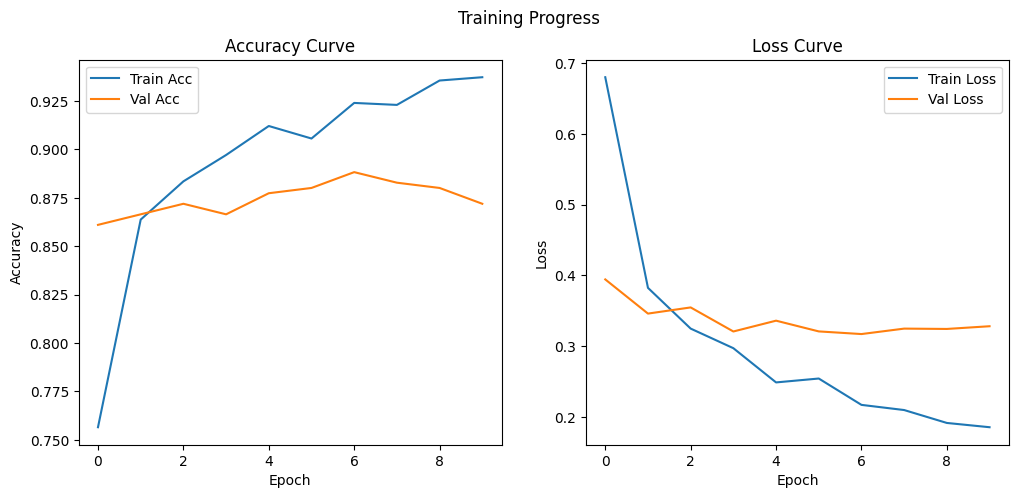

In [27]:
# Plot loss and accuracy curves
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.suptitle("Training Progress")
plt.show()

Evaluate the best saved model on the test split, and show overall accuracy and loss.

In [ ]:
model = tf.keras.models.load_model(SAVE_PATH)
test_loss, test_acc = model.evaluate(test_ds)
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")

Accuracy and Loss

In [34]:
print(f"\nTest accuracy: {test_acc:.4f}")
print(f"Test loss: {test_loss:.4f}")


Test accuracy: 0.8910
Test loss: 0.3194


Release dataset and TensorFlow resources to free memory.

In [35]:
del ds_train, ds_validation, ds_test, train_ds, val_ds, test_ds
tf.keras.backend.clear_session()